In [1]:
# leaf_classification_2.ipynb
# =================================
# This notebook focuses on using Histogram of Oriented Gradients (HOG) features

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os                        # To navigate directories
import cv2                       # For image I/O and processing
import numpy as np               # For numerical operations
import matplotlib.pyplot as plt  # For visualization
from skimage.feature import hog  # For HOG feature extraction
from sklearn.model_selection import train_test_split  # To split data
from sklearn.neighbors import KNeighborsClassifier    # k-NN classifier
from sklearn.tree import DecisionTreeClassifier       # Decision Tree classifier
from sklearn.metrics import classification_report, confusion_matrix  # Evaluation metrics
from sklearn.preprocessing import LabelEncoder        # To encode labels

In [4]:
# 1. Lets define dataset directories
base_dir = '/content/drive/MyDrive/archive/train/train'
# Get sorted class names from train folder
class_names = [d for d in sorted(os.listdir(base_dir)) if os.path.isdir(os.path.join(base_dir, d))]

In [5]:
# 2. Loading images and labels
def load_images_and_labels(folder):
    images = []  # store image arrays
    labels = []  # store corresponding class labels
    # Iterate through each class folder
    for cls in class_names:
        cls_folder = os.path.join(folder, cls)
        # Iterate through image files in the class folder
        for file in os.listdir(cls_folder):
            if file.lower().endswith(('.jpg', '.png')):
                img_path = os.path.join(cls_folder, file)
                img = cv2.imread(img_path)  # BGR image
                if img is None:
                    continue  # skip unreadable files
                images.append(img)
                labels.append(cls)
    return images, labels

# Loading training data
images, labels = load_images_and_labels(base_dir)
print(f"Loaded {len(images)} images for HOG-based classification.")

Loaded 4284 images for HOG-based classification.


In [6]:
# 3. Extracting HOG features
def extract_hog(img, resize=(128, 128)):
    # Resize image to fixed size for consistency
    img_resized = cv2.resize(img, resize)
    # Convert to grayscale as HOG works on single channel
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    # Extract HOG features and HOG visualization image
    features, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )
    return features, hog_image

# Compute HOG features for all images
hog_features_list = []  # to collect feature vectors
hog_images = []         # to collect hog visualizations for later display
for img in images:
    feats, hog_img = extract_hog(img)
    hog_features_list.append(feats)
    hog_images.append(hog_img)
# Convert list to NumPy array
X = np.array(hog_features_list)

# Encode labels to integers
le = LabelEncoder()
y = le.fit_transform(labels)
class_names = le.classes_  # save ordered class names

print(f"HOG feature matrix shape: {X.shape}")

HOG feature matrix shape: (4284, 8100)


In [7]:
# 4. Splitting data into train and test sets
X_train, X_test, y_train, y_test, img_train, img_test, hog_train_imgs, hog_test_imgs = train_test_split(
    X, y, images, hog_images,
    test_size=0.2,
    random_state=42
)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 3427, Testing samples: 857


In [8]:
# 5. Training classifiers
# a) k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# b) Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [9]:
# 6. Evaluating performance
print("k-NN Classification Report:")
print(classification_report(y_test, knn_pred, target_names=class_names))
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred, target_names=class_names))

k-NN Classification Report:
                    precision    recall  f1-score   support

Alstonia Scholaris       0.84      0.79      0.82        96
             Arjun       0.73      0.78      0.75        89
              Bael       1.00      0.44      0.62        18
             Basil       0.57      0.84      0.68        32
            Chinar       0.96      0.59      0.73        46
             Gauva       0.68      0.64      0.66        94
             Jamun       0.94      0.70      0.80       107
          Jatropha       1.00      0.42      0.59        52
             Lemon       0.78      0.74      0.76        42
             Mango       0.79      0.85      0.82        73
       Pomegranate       0.52      0.94      0.67        98
  Pongamia Pinnata       0.92      0.88      0.90       110

          accuracy                           0.75       857
         macro avg       0.81      0.72      0.73       857
      weighted avg       0.80      0.75      0.76       857

Decision 

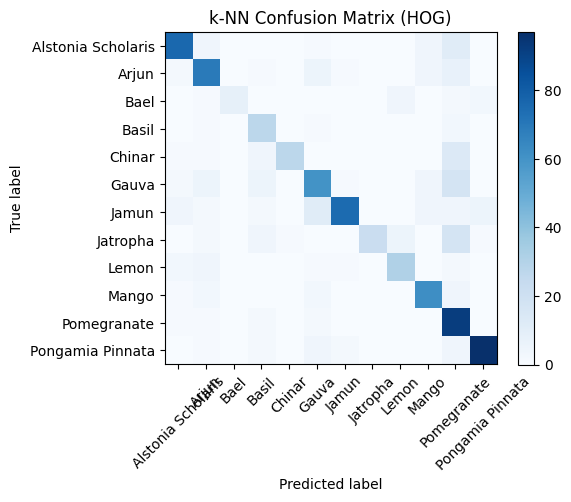

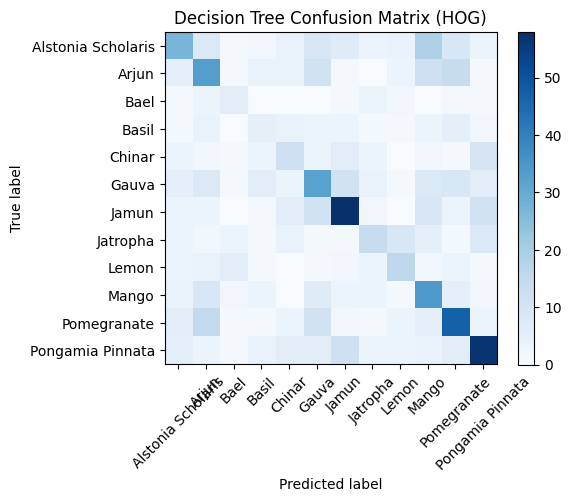

In [10]:
# 7. Confusion matrices visualization
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, knn_pred, 'k-NN Confusion Matrix (HOG)')
plot_confusion_matrix(y_test, dt_pred, 'Decision Tree Confusion Matrix (HOG)')

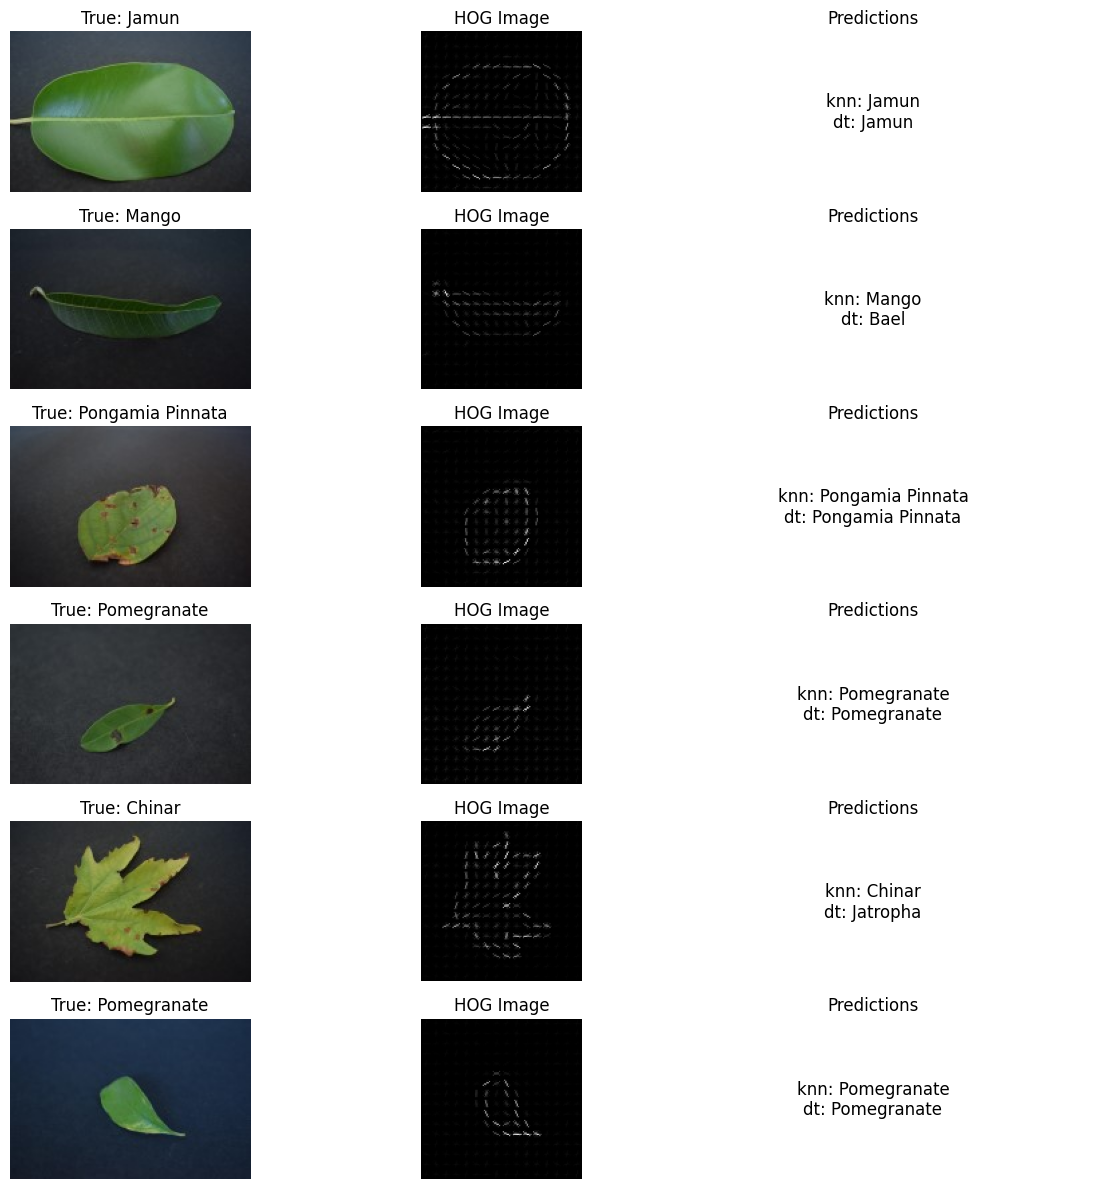

In [11]:
# 8. Visualization of sample HOG and predictions
# Display first 6 test samples: original image, its HOG visualization, and true vs predicted labels
plt.figure(figsize=(12, 12))
for i in range(6):
    # Original image subplot
    ax1 = plt.subplot(6, 3, 3*i + 1)
    ax1.imshow(cv2.cvtColor(img_test[i], cv2.COLOR_BGR2RGB))
    ax1.set_title(f"True: {le.inverse_transform([y_test[i]])[0]}")
    ax1.axis('off')
    # HOG visualization subplot
    ax2 = plt.subplot(6, 3, 3*i + 2)
    ax2.imshow(hog_test_imgs[i], cmap='gray')
    ax2.set_title('HOG Image')
    ax2.axis('off')
    # Prediction subplot
    ax3 = plt.subplot(6, 3, 3*i + 3)
    pred_label = le.inverse_transform([knn_pred[i]])[0]
    ax3.text(0.5, 0.5, f"knn: {pred_label}\ndt: {le.inverse_transform([dt_pred[i]])[0]}",
             horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax3.set_title('Predictions')
    ax3.axis('off')
plt.tight_layout()
plt.show()